In [1]:
import xarray as xr
import pandas as pd
import pop_tools
import numpy as np
import cftime
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from datetime import datetime
import glob
import flox

# Spinning up a Dask cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='4:00:00')

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/eromashkova/miniconda3/envs/diag-sandbox-moc-pop-tools/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/eromashkova/miniconda3/envs/diag-sandbox-moc-pop-tools/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43499 instead
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/diag-sandbox-moc-pop-tools/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also ch

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/43499/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/43499/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:44793,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/43499/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Reading in SAU catch data

In [5]:
df = pd.read_csv('data/SAUP_LME_Catch_annual_newF.csv')

true_catch = df.set_index(["Year", "LMEID"]).to_xarray()

true_catch

### units on catch variables are g wet weight m-2 per year

<xarray.Dataset>
Dimensions:  (Year: 61, LMEID: 65)
Coordinates:
  * Year     (Year) int64 1950 1951 1952 1953 1954 ... 2006 2007 2008 2009 2010
  * LMEID    (LMEID) int64 1 2 3 4 5 6 7 8 9 10 ... 57 58 59 60 61 62 63 65 66
Data variables:
    FwCatch  (Year, LMEID) float64 26.91 154.4 5.209e+03 0.0 ... 63.51 202.2 0.0
    PwCatch  (Year, LMEID) float64 5.118e+04 3.992e+05 ... 4.185e+04 0.008851
    DwCatch  (Year, LMEID) float64 2.473e+04 2.227e+05 ... 8.225e+05 9.241

# Reading in modeled FEISTY data

In [6]:
path = '/glade/scratch/kristenk/feisty_hires_proc/'
files = sorted(glob.glob(f'{path}/FEISTY-hi-res-x0.1-????.nc'))

ds = xr.open_mfdataset(files,concat_dim="time", coords='minimal', compat="override", combine='nested')

ds['time'] = np.arange(1980,2022,1)
    
chunks = {'nlat': 8, 'nlon': 8, 'time': 42} 

ds.chunk(chunks)

<xarray.Dataset>
Dimensions:     (time: 42, group: 9, nlat: 2400, nlon: 3600, fish: 8)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399
  * nlon        (nlon) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
  * time        (time) int64 1980 1981 1982 1983 1984 ... 2018 2019 2020 2021
Data variables:
    biomass     (time, group, nlat, nlon) float64 dask.array<chunksize=(42, 9, 8, 8), meta=np.ndarray>
    fish_yield  (time, fish, nlat, nlon) float64 dask.array<chunksize=(42, 8, 8, 8), meta=np.ndarray>
    production  (time, fish, nlat, nlon) float64 dask.array<chunksize=(42, 8, 8, 8), meta=np.ndarray>

# Resampling data by LMEs

## Reading in 0.1 degree LME mask

In [7]:
coords_dict = {'nlat': ds.nlat.data, 'nlon': ds.nlon.data}

In [9]:
ds_lme_x01 = xr.open_dataset("data/LME-mask-POP_tx0.1v3.nc").assign_coords(coords_dict)
ds_lme_x01 

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600)
Coordinates:
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
  * nlat      (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon      (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
Data variables:
    lme_mask  (nlat, nlon) float64 ...
    KMT       (nlat, nlon) int32 ...
    TAREA     (nlat, nlon) float64 ...
Attributes:
    regrid_method:  nearest_s2d

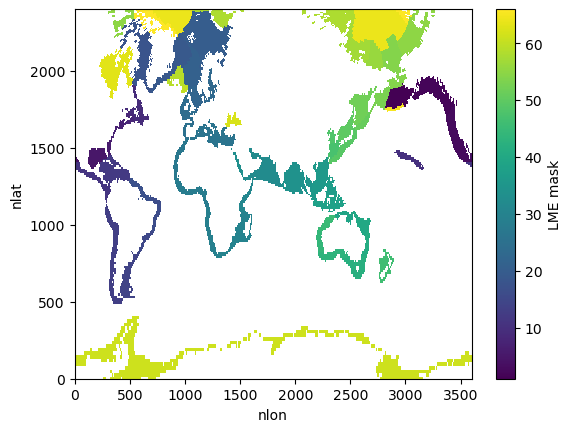

In [10]:
ds_lme_x01.lme_mask.plot()

## Reading in grid variables

In [11]:
chunks = {'nlat': 8, 'nlon': 1200}

In [12]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3').assign_coords(coords_dict)
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4 # Converting area unit to m^2 (from cm^2)

## Getting list of all LME indices (removing 64, which doesn't have SAU data)

In [13]:
all_lmes = list(np.arange(1,67))
all_lmes.remove(64)
print(all_lmes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66]


## Creating an empty dataset for the modeled catch

In [14]:
modeled_catch = xr.Dataset(coords={"Year": ("Year", np.arange(1980, 2022)),
                "LMEID": ("LMEID", true_catch.LMEID.data)}, 
                           data_vars={'FwCatch': (["Year", "LMEID"], np.zeros((42,65))),
                                      'PwCatch': (["Year", "LMEID"], np.zeros((42,65))),
                                      'DwCatch': (["Year", "LMEID"], np.zeros((42,65)))
                                     })

In [15]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon')).assign_coords(coords_dict)
ones = ones.where(ds_grid.REGION_MASK>0, 0)


for lme in all_lmes[:]:
    print('lme = ', lme)
        
    # Setting up LME masking
    mask_x01 = ones.where(ds_lme_x01.lme_mask == lme)
    masked_area_x01 = area_m.where(ds_lme_x01.lme_mask == lme)
    print('summing area')
    tot_masked_area_x01 = masked_area_x01.sum(dim=('nlon','nlat'))
    print(tot_masked_area_x01.values)
    
    masked_var = ds["fish_yield"].where(mask_x01==1)
    
    # double check that this is working over each fish type
    masked_var = masked_var.where(masked_var < 0.5)
    masked_var = masked_var.where(masked_var > -0.001)
    print('summing masked var')
    tot_masked_var = (masked_var * masked_area_x01).sum(dim=('nlon','nlat'))
    #tot_masked_var = (masked_var).sum(dim=('nlon','nlat'))
    print('dividing by area')
    ds_tmp =  tot_masked_var / tot_masked_area_x01
    
    for year in np.arange(1980, 2022):
        print(year)
        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
                
        total_forage = 0
        total_pelagic = 0
        total_demersal = 0
        
        for fish_type in ["Sf", "Mf"]:
            total_forage += float(ds_tmp.sel(fish=fish_type).sel(time=year))
        for fish_type in ["Sp", "Mp", "Lp"]:
            total_pelagic += float(ds_tmp.sel(fish=fish_type).sel(time=year))
        for fish_type in ["Sd", "Md", "Ld"]:
            total_demersal += float(ds_tmp.sel(fish=fish_type).sel(time=year))
            
        print(total_forage)
        print(total_pelagic)
        print(total_demersal)

 
        modeled_catch.FwCatch.loc[dict(Year=year, LMEID=lme)] = total_forage
        modeled_catch.PwCatch.loc[dict(Year=year, LMEID=lme)] = total_pelagic
        modeled_catch.DwCatch.loc[dict(Year=year, LMEID=lme)] = total_demersal
        
    modeled_catch.sel(LMEID=lme).to_zarr(store="data/FEISTY_SAU_comparison_x01/modeled_catch_by_lme_" + str(lme) + ".zarr")
                  

lme =  1
summing area
1272275648600.4734
summing masked var
dividing by area
1980
Current Time = 16:59:20
0.002787131559683013
0.0011688477991032733
0.003810405689598455
1981
Current Time = 16:59:41
0.00290957464388598
0.0011974845890466517
0.003818691874168391
1982
Current Time = 16:59:59
0.0029274306469769485
0.0012448503306155096
0.003726787992026247
1983
Current Time = 17:00:12
0.0028296196425656134
0.0012680008804506072
0.0035723872246489715
1984
Current Time = 17:00:26
0.0029358205574826937
0.0013050512388703165
0.0034310423245669133
1985
Current Time = 17:00:38
0.0029356536857342514
0.0013297048353971882
0.0033193480603605353
1986
Current Time = 17:00:50
0.002764331520212753
0.0013062434568946227
0.003325769793773598
1987
Current Time = 17:01:01
0.002827948926694202
0.0012865633550447036
0.003467321304066955
1988
Current Time = 17:01:14
0.0028033849207382794
0.0012721370095930698
0.0035969982388071196
1989
Current Time = 17:01:26
0.0028591853329115965
0.0012796719469869685
0.003

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
plt.scatter(true_catch.FwCatch.sel(Year=1981), modeled_catch.FwCatch.sel(Year=1981))
plt.xlabel("SAU")
plt.ylabel("FEISTY")

plt.show()

